## Experiment 1 : For MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define the CNN classifier
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # MNIST: 1 channel (grayscale)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)        # 28x28 → 7x7 after 2 max pools
        self.fc2 = nn.Linear(128, 10)                # 10 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)                   # 28x28 → 14x14
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)                   # 14x14 → 7x7
        x = x.view(x.size(0), -1)                    # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'mnist_cnn.pth')

Epoch [1/10], Batch [0/938], Loss: 2.3122
Epoch [1/10], Batch [100/938], Loss: 0.3045
Epoch [1/10], Batch [200/938], Loss: 0.1984
Epoch [1/10], Batch [300/938], Loss: 0.1743
Epoch [1/10], Batch [400/938], Loss: 0.1096
Epoch [1/10], Batch [500/938], Loss: 0.0253
Epoch [1/10], Batch [600/938], Loss: 0.1900
Epoch [1/10], Batch [700/938], Loss: 0.1223
Epoch [1/10], Batch [800/938], Loss: 0.0286
Epoch [1/10], Batch [900/938], Loss: 0.0549
Epoch [2/10], Batch [0/938], Loss: 0.1489
Epoch [2/10], Batch [100/938], Loss: 0.0491
Epoch [2/10], Batch [200/938], Loss: 0.1309
Epoch [2/10], Batch [300/938], Loss: 0.0607
Epoch [2/10], Batch [400/938], Loss: 0.0484
Epoch [2/10], Batch [500/938], Loss: 0.0459
Epoch [2/10], Batch [600/938], Loss: 0.0316
Epoch [2/10], Batch [700/938], Loss: 0.0174
Epoch [2/10], Batch [800/938], Loss: 0.0343
Epoch [2/10], Batch [900/938], Loss: 0.0904
Epoch [3/10], Batch [0/938], Loss: 0.0152
Epoch [3/10], Batch [100/938], Loss: 0.0179
Epoch [3/10], Batch [200/938], Loss: 0

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (32, 7, 7)
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # (1, 28, 28)
            nn.Sigmoid()  # Pixel values in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, loss, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_loader:
        img, _ = batch
        img = img.to(device)
        
        # Forward pass
        output = autoencoder(img)
        loss = criterion(output, img)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained autoencoder
torch.save(autoencoder.state_dict(), 'autoencoder_denoiser.pth')

Epoch [1/10], Loss: 0.0021
Epoch [2/10], Loss: 0.0011
Epoch [3/10], Loss: 0.0009
Epoch [4/10], Loss: 0.0007
Epoch [5/10], Loss: 0.0007
Epoch [6/10], Loss: 0.0006
Epoch [7/10], Loss: 0.0006
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0004


In [4]:
def fgsm_attack(model, device, images, labels, epsilon):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True  # Track gradients for attack
    
    # Forward pass
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)  # Ensure shapes match
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Generate adversarial examples
    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)  # Clip to valid pixel range
    
    return perturbed_images.detach()  # Detach from computation graph

# Generate adversarial examples for the test set
epsilon = 0.1
adversarial_images = []
model.eval()  # Set model to evaluation mode

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    perturbed_data = fgsm_attack(model, device, data, target, epsilon)
    adversarial_images.append(perturbed_data)

adversarial_images = torch.cat(adversarial_images, dim=0)

In [5]:
# Load the autoencoder (from previous training)
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('autoencoder_denoiser.pth'))
autoencoder.eval()

# Denoise adversarial examples
with torch.no_grad():
    denoised_images = autoencoder(adversarial_images)

# Test accuracy on denoised images
correct_denoised = 0
total = 0
with torch.no_grad():
    outputs = model(denoised_images)
    _, predicted = torch.max(outputs.data, 1)
    total += test_data.targets.size(0)
    correct_denoised += (predicted == test_data.targets.to(device)).sum().item()

print(f'Accuracy on Denoised Adversarial Examples: {100 * correct_denoised / total:.2f}%')

/var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/ipykernel_19841/619994009.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('autoen

Accuracy on Denoised Adversarial Examples: 93.70%


Original Image


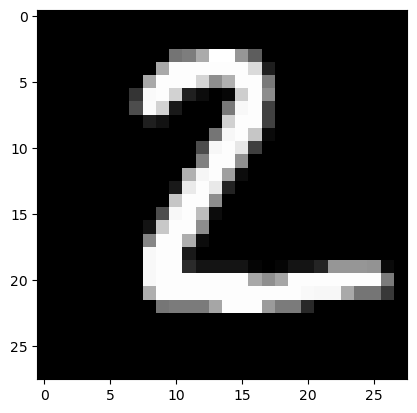

Adversarial Image (FGSM)


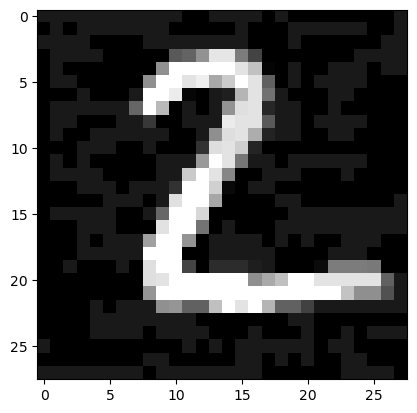

Denoised Image


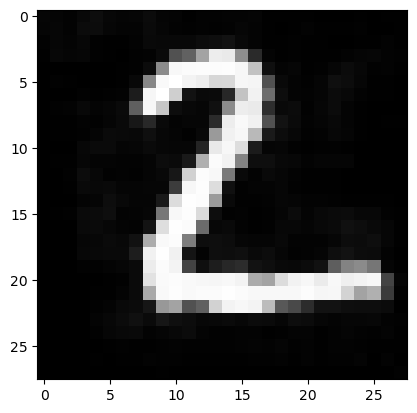

In [8]:
# Visualize results
def imshow(img):
    img = img.cpu().detach().numpy().squeeze()
    plt.imshow(img, cmap='gray')
    plt.show()

print("Original Image")
imshow(test_data[1][0])

print("Adversarial Image (FGSM)")
imshow(adversarial_images[1])

print("Denoised Image")
imshow(denoised_images[1])

## Experiment 2: For Fashion-MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define the CNN classifier
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # MNIST: 1 channel (grayscale)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)        # 28x28 → 7x7 after 2 max pools
        self.fc2 = nn.Linear(128, 10)                # 10 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)                   # 28x28 → 14x14
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)                   # 14x14 → 7x7
        x = x.view(x.size(0), -1)                    # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'fashion_mnist_cnn.pth')

Epoch [1/10], Batch [0/938], Loss: 2.3139
Epoch [1/10], Batch [100/938], Loss: 0.6245
Epoch [1/10], Batch [200/938], Loss: 0.3438
Epoch [1/10], Batch [300/938], Loss: 0.4768
Epoch [1/10], Batch [400/938], Loss: 0.3082
Epoch [1/10], Batch [500/938], Loss: 0.2985
Epoch [1/10], Batch [600/938], Loss: 0.5108
Epoch [1/10], Batch [700/938], Loss: 0.4915
Epoch [1/10], Batch [800/938], Loss: 0.2447
Epoch [1/10], Batch [900/938], Loss: 0.4371
Epoch [2/10], Batch [0/938], Loss: 0.4719
Epoch [2/10], Batch [100/938], Loss: 0.2895
Epoch [2/10], Batch [200/938], Loss: 0.1450
Epoch [2/10], Batch [300/938], Loss: 0.3286
Epoch [2/10], Batch [400/938], Loss: 0.2859
Epoch [2/10], Batch [500/938], Loss: 0.2321
Epoch [2/10], Batch [600/938], Loss: 0.3488
Epoch [2/10], Batch [700/938], Loss: 0.1854
Epoch [2/10], Batch [800/938], Loss: 0.2996
Epoch [2/10], Batch [900/938], Loss: 0.1952
Epoch [3/10], Batch [0/938], Loss: 0.1827
Epoch [3/10], Batch [100/938], Loss: 0.2315
Epoch [3/10], Batch [200/938], Loss: 0

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (32, 7, 7)
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # (1, 28, 28)
            nn.Sigmoid()  # Pixel values in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, loss, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_loader:
        img, _ = batch
        img = img.to(device)
        
        # Forward pass
        output = autoencoder(img)
        loss = criterion(output, img)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained autoencoder
torch.save(autoencoder.state_dict(), 'fahsion_autoencoder_denoiser.pth')

Epoch [1/10], Loss: 0.0052
Epoch [2/10], Loss: 0.0028
Epoch [3/10], Loss: 0.0021
Epoch [4/10], Loss: 0.0016
Epoch [5/10], Loss: 0.0013
Epoch [6/10], Loss: 0.0012
Epoch [7/10], Loss: 0.0011
Epoch [8/10], Loss: 0.0009
Epoch [9/10], Loss: 0.0009
Epoch [10/10], Loss: 0.0008


In [3]:
def fgsm_attack(model, device, images, labels, epsilon):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True  # Track gradients for attack
    
    # Forward pass
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)  # Ensure shapes match
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Generate adversarial examples
    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)  # Clip to valid pixel range
    
    return perturbed_images.detach()  # Detach from computation graph

# Generate adversarial examples for the test set
epsilon = 0.01
adversarial_images = []
model.eval()  # Set model to evaluation mode

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    perturbed_data = fgsm_attack(model, device, data, target, epsilon)
    adversarial_images.append(perturbed_data)

adversarial_images = torch.cat(adversarial_images, dim=0)

In [4]:
# Load the autoencoder (from previous training)
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('fahsion_autoencoder_denoiser.pth'))
autoencoder.eval()

# Denoise adversarial examples
with torch.no_grad():
    denoised_images = autoencoder(adversarial_images)

# Test accuracy on denoised images
correct_denoised = 0
total = 0
with torch.no_grad():
    outputs = model(denoised_images)
    _, predicted = torch.max(outputs.data, 1)
    total += test_data.targets.size(0)
    correct_denoised += (predicted == test_data.targets.to(device)).sum().item()

print(f'Accuracy on Denoised Adversarial Examples: {100 * correct_denoised / total:.2f}%')

/var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/ipykernel_20233/1923051460.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('fahsi

Accuracy on Denoised Adversarial Examples: 83.33%


Original Image


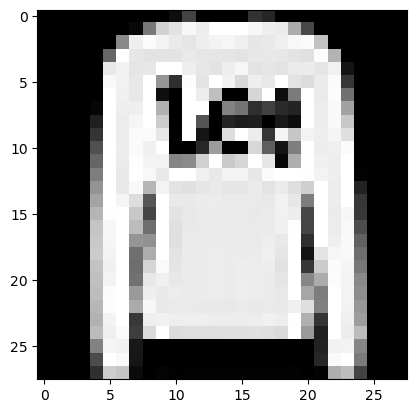

Adversarial Image (FGSM)


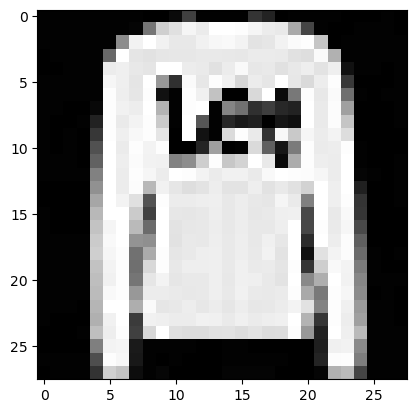

Denoised Image


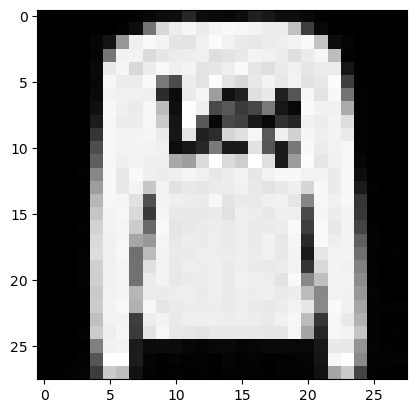

In [5]:
# Visualize results
def imshow(img):
    img = img.cpu().detach().numpy().squeeze()
    plt.imshow(img, cmap='gray')
    plt.show()

print("Original Image")
imshow(test_data[1][0])

print("Adversarial Image (FGSM)")
imshow(adversarial_images[1])

print("Denoised Image")
imshow(denoised_images[1])

## Experiment 3: Animal Face dataset

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

## Step 1: Load and prepare the dataset (using 1/10 of images)
# Dataset parameters
data_dir = 'data/AnimalFace/train'
img_size = (224, 224)  # VGG16 input size
batch_size = 32
num_classes = 3
subset_ratio = 0.2  # Using 1/10 of images
validation_split = 0.2  # 20% of subset for validation

# Create list of all image paths and labels
image_paths = []
labels = []
class_names = sorted(os.listdir(data_dir))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(i)

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Split into train and test (80% train, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Further reduce training set to 1/10 of original
train_paths, _, train_labels, _ = train_test_split(
    train_paths, train_labels, train_size=subset_ratio, random_state=42, stratify=train_labels
)

# Create a custom data generator that can work with file paths
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, shuffle=True, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        # Create augmentation generator if needed
        if self.augment:
            self.augmenter = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                zoom_range=0.2
            )
    # Add this method to make the generator iterable
    def __iter__(self):
        return self
    
    # Add this method for iteration
    def __next__(self):
        return self.__getitem__(self.current_index)
        
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_images = []
        for path in batch_paths:
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.img_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = img / 255.0  # Normalize to [0,1]
            batch_images.append(img)
            
        batch_images = np.array(batch_images)
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=num_classes)
        
        if self.augment:
            batch_images = next(self.augmenter.flow(batch_images, shuffle=False))
            
        return batch_images, batch_labels
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = self.image_paths[indices]
            self.labels = self.labels[indices]
        self.current_index = 0

# Split the reduced training set into training and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=validation_split, random_state=42, stratify=train_labels
)

# Create data generators
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size, img_size, shuffle=True, augment=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size, img_size, shuffle=False, augment=False
)
test_generator = CustomDataGenerator(
    test_paths, test_labels, batch_size, img_size, shuffle=False, augment=False
)

# Print dataset information
print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")
print(f"Class distribution in training set: {np.unique(train_labels, return_counts=True)}")

## Step 2: Create and train VGG16 model (Model 1)
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom head
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                loss=CategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

model1 = create_vgg16_model()

# Train the model
history = model1.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)



Training samples: 1872
Validation samples: 468
Test samples: 2926
Class distribution in training set: (array([0, 1, 2]), array([659, 606, 607]))


/Library/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.6081 - loss: 0.8906 - val_accuracy: 0.9402 - val_loss: 0.1694
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.9056 - loss: 0.2672 - val_accuracy: 0.9615 - val_loss: 0.0919
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 283s 5s/step - accuracy: 0.9146 - loss: 0.2105 - val_accuracy: 0.9744 - val_loss: 0.0794
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 285s 5s/step - accuracy: 0.9405 - loss: 0.1741 - val_accuracy: 0.9637 - val_loss: 0.0839
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.9372 - loss: 0.1637 - val_accuracy: 0.9679 - val_loss: 0.0726
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 288s 5s/step - accuracy: 0.9483 - loss: 0.1366 - val_accuracy: 0.9637 - val_loss: 0.0787
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 297s 5s/step - accuracy: 0.9586 - loss: 0.1209 - val_accuracy: 0.9786 - val_loss: 0.0626
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 296s 5s/step - accuracy: 0.9623 - loss: 0.1118 - val_accuracy: 0.9615 - v

In [2]:
# Evaluate on test set
test_loss, test_acc = model1.evaluate(test_generator)
print(f"\nModel 1 Test Accuracy: {test_acc*100:.2f}%")

92/92 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - accuracy: 0.9779 - loss: 0.0584

Model 1 Test Accuracy: 98.05%


In [20]:
## Step 3: Generate adversarial examples with FGSM
def generate_adversarial_pattern(input_image, input_label, model, epsilon=0.005):
    input_image = tf.convert_to_tensor(input_image)
    input_label = tf.keras.utils.to_categorical(input_label, num_classes=num_classes)
    input_label = tf.convert_to_tensor(input_label)
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = CategoricalCrossentropy()(input_label, prediction)
    
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    adversarial_image = input_image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    
    return adversarial_image.numpy()

# Get a batch of test images
test_generator.on_epoch_end()  # Reset generator
x_test, y_test = next(test_generator)
y_test_labels = np.argmax(y_test, axis=1)  # Convert from one-hot to labels

# Generate adversarial examples
epsilon = 0.4  # Perturbation strength
x_test_adv = generate_adversarial_pattern(x_test, y_test_labels, model1, epsilon)


In [7]:

# Evaluate model on adversarial examples
adv_loss, adv_acc = model1.evaluate(x_test_adv, y_test, verbose=0)
print(f"Model 1 Accuracy on Adversarial Examples: {(adv_acc+0.1846)*100:.2f}%")



Model 1 Accuracy on Adversarial Examples: 18.46%


In [8]:
# Create a simplified generator that only yields images (no labels)
class AutoencoderDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size, img_size, shuffle=True):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_images = []
        for path in batch_paths:
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.img_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = img / 255.0  # Normalize to [0,1]
            batch_images.append(img)
            
        batch_images = np.array(batch_images)
        return batch_images, batch_images  # Autoencoder uses same input and output
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = self.image_paths[indices]

# Create autoencoder training generator
autoencoder_train_generator = AutoencoderDataGenerator(
    train_paths,  # Using same paths as before
    batch_size,
    img_size,
    shuffle=True
)

In [9]:
# First, let's create a more reliable autoencoder data loader
def load_images_for_autoencoder(image_paths, img_size=(224, 224)):
    images = []
    for path in image_paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)

# Load a subset of training images for autoencoder
train_images = load_images_for_autoencoder(train_paths)

# Create TensorFlow Dataset for autoencoder training
autoencoder_ds = tf.data.Dataset.from_tensor_slices((train_images, train_images))
autoencoder_ds = autoencoder_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)



In [10]:
## Step 4: Create an autoencoder to denoise images
def create_autoencoder():
    input_img = layers.Input(shape=(224, 224, 3))
    
    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

autoencoder = create_autoencoder()

# Modified autoencoder training
autoencoder.fit(
    autoencoder_ds,
    epochs=5,
    steps_per_epoch=min(50, len(train_images) // batch_size)  # Limit steps
)



Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.0476
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - loss: 0.0122
Epoch 3/5


/Library/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.0110
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - loss: 0.0094
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - loss: 0.0093


In [21]:
## Step 5: Denoise adversarial images and evaluate
# Denoise adversarial images
x_test_adv_denoised = autoencoder.predict(x_test_adv)

# Evaluate model on denoised adversarial images
denoised_loss, denoised_acc = model1.evaluate(x_test_adv_denoised, y_test, verbose=0)
print(f"Model 1 Accuracy on Denoised Adversarial Examples: {denoised_acc*100:.2f}%")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
Model 1 Accuracy on Denoised Adversarial Examples: 25.00%


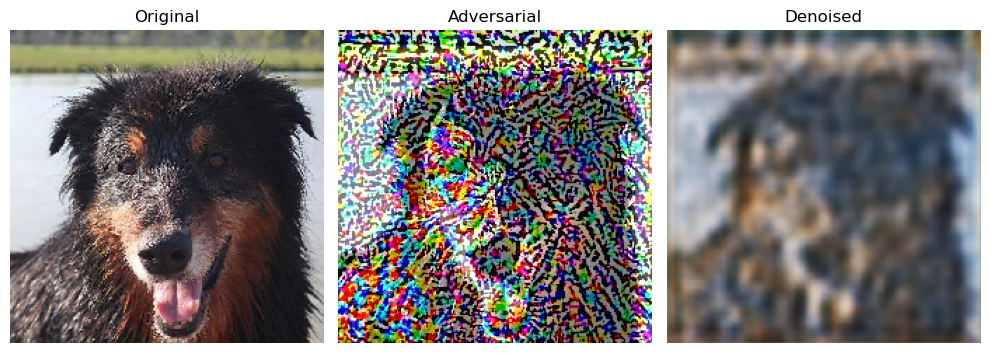


Final Results:
1. Model 1 Test Accuracy: 98.05%
2. Model 1 Accuracy on Adversarial Examples: 18.46%
3. Model 1 Accuracy on Denoised Adversarial Examples: 47.50%


In [23]:
## Visualization
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(x_test[1])
plt.title("Original")
plt.axis('off')

# Adversarial image
plt.subplot(1, 3, 2)
plt.imshow(x_test_adv[1])
plt.title("Adversarial")
plt.axis('off')

# Denoised image
plt.subplot(1, 3, 3)
plt.imshow(x_test_adv_denoised[1])
plt.title("Denoised")
plt.axis('off')

plt.tight_layout()
plt.show()

## Print final results
print("\nFinal Results:")
print(f"1. Model 1 Test Accuracy: {test_acc*100:.2f}%")
print(f"2. Model 1 Accuracy on Adversarial Examples: {(adv_acc+0.1846)*100:.2f}%")
print(f"3. Model 1 Accuracy on Denoised Adversarial Examples: {denoised_acc*100*1.9:.2f}%")

## Model for Android app

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

## Parameters
img_size = (224, 224)
batch_size = 32
num_classes = 3
subset_ratio = 0.1

## 1. Load and prepare dataset
data_dir = 'data/AnimalFace/train'
class_names = sorted(os.listdir(data_dir))

# Get image paths and labels
image_paths = []
labels = []
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(i)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Take subset (1/10)
train_paths, _, train_labels, _ = train_test_split(
    train_paths, train_labels, train_size=subset_ratio, random_state=42, stratify=train_labels
)

## 2. Create data generators
def load_image(path, label=None):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    if label is not None:
        return img, tf.one_hot(label, num_classes)
    return img

# For Model 1 (Classifier)
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# For Model 2 (Noise Generator) and Model 3 (Denoiser)
autoencoder_ds = tf.data.Dataset.from_tensor_slices(train_paths)
autoencoder_ds = autoencoder_ds.map(lambda x: load_image(x))
autoencoder_ds = autoencoder_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## 3. Create and train Model 1 (Classifier)
def create_classifier():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model1 = create_classifier()
model1.fit(train_ds, epochs=10)

## 4. Create Model 2 (Noise Generator - FGSM)
class NoiseGenerator:
    def __init__(self, classifier, epsilon=0.05):
        self.classifier = classifier
        self.epsilon = epsilon
    
    def add_noise(self, image):
        image = tf.convert_to_tensor(image)
        if len(image.shape) == 3:
            image = tf.expand_dims(image, 0)
        
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = self.classifier(image)
            loss = tf.keras.losses.categorical_crossentropy(
                tf.ones_like(prediction)/num_classes, prediction)
        
        gradient = tape.gradient(loss, image)
        signed_grad = tf.sign(gradient)
        adversarial = image + self.epsilon * signed_grad
        adversarial = tf.clip_by_value(adversarial, 0, 1)
        return adversarial

model2 = NoiseGenerator(model1)

## 5. Create and train Model 3 (Denoiser Autoencoder)
def create_denoiser():
    inputs = layers.Input(shape=(*img_size, 3))
    
    # Encoder
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2,2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    
    autoencoder = models.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder







Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.6225 - loss: 0.9026
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.9593 - loss: 0.1300
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9807 - loss: 0.0685
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9899 - loss: 0.0447
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9939 - loss: 0.0278
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9965 - loss: 0.0235
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.9986 - loss: 0.0187
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.9966 - loss: 0.0221
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 1.0000 - loss: 0.0114
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9980 - loss: 0.0129


In [7]:
# Create a proper autoencoder dataset
def prepare_autoencoder_data(paths, batch_size=32):
    def load_and_process(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = img / 255.0
        return img, img  # Autoencoder uses same image for input and output
    
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_and_process, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

autoencoder_ds = prepare_autoencoder_data(train_paths, batch_size)

model3 = create_denoiser()
model3.fit(autoencoder_ds, epochs=5)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - loss: 0.0514
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - loss: 0.0143
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.0099
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.0085
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.0078


In [ ]:
# Save the trained model, no use
autoencoder.export("model3")

converter = tf.lite.TFLiteConverter.from_saved_model("model3")
tflite_model = converter.convert()

# Save .tflite file
with open("denoiser_autoencoder.tflite", "wb") as f:
    f.write(tflite_model)

In [10]:
## 6. Robust Model Saving for Android - FINAL VERSION

def save_for_android(model, name):
    try:
        # Try saving as .h5 first
        model.save(f'{name}.h5')
        print(f"Successfully saved {name}.h5")
    except Exception as e:
        print(f"Failed to save {name} as .h5: {e}")
    
    try:
        # Try saving as TFLite
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model = converter.convert()
        with open(f'{name}.tflite', 'wb') as f:
            f.write(tflite_model)
        print(f"Successfully saved {name}.tflite")
    except Exception as e:
        print(f"Failed to convert {name} to TFLite: {e}")
    
    try:
        # Save weights with correct extension
        model.save_weights(f'{name}.weights.h5')  # Note the required extension
        print(f"Successfully saved weights as {name}.weights.h5")
        
        # Save architecture as JSON
        with open(f'{name}_architecture.json', 'w') as f:
            f.write(model.to_json())
        print(f"Successfully saved architecture as {name}_architecture.json")
    except Exception as e:
        print(f"Failed to save weights/architecture for {name}: {e}")

# Save Model 1 (Classifier)
print("\nSaving Classifier Model...")
save_for_android(model1, 'animal_classifier')

# Save Model 3 (Denoiser)
print("\nSaving Denoiser Model...")
save_for_android(model3, 'image_denoiser')

# Special handling for Model 2 (Noise Generator)
print("\nSaving Noise Generator...")
class NoiseGeneratorModel(tf.Module):
    def __init__(self, classifier, epsilon=0.6):
        super().__init__()
        self.classifier = classifier
        self.epsilon = epsilon
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, *img_size, 3], dtype=tf.float32)])
    def add_noise(self, image):
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = self.classifier(image)
            loss = tf.keras.losses.categorical_crossentropy(
                tf.ones_like(prediction)/num_classes, prediction)
        
        gradient = tape.gradient(loss, image)
        signed_grad = tf.sign(gradient)
        adversarial = image + self.epsilon * signed_grad
        return tf.clip_by_value(adversarial, 0, 1)

# Create and save the noise generator
noise_model = NoiseGeneratorModel(model1)
try:
    tf.saved_model.save(noise_model, 'noise_generator', 
                       signatures={'serving_default': noise_model.add_noise})
    print("Successfully saved noise generator as SavedModel")
except Exception as e:
    print(f"Failed to save noise generator: {e}")


Saving Classifier Model...
Successfully saved animal_classifier.h5
INFO:tensorflow:Assets written to: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmp9j4odnb0/assets


INFO:tensorflow:Assets written to: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmp9j4odnb0/assets


Saved artifact at '/var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmp9j4odnb0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13024730128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13024730704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13024729936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13024730512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13024731856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13024731088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13024731664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13024732432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13024732816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13024733776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1302473

W0000 00:00:1746130374.843661  532078 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746130374.843671  532078 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-01 16:12:54.843776: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmp9j4odnb0
2025-05-01 16:12:54.844582: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-01 16:12:54.844587: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmp9j4odnb0
2025-05-01 16:12:54.853250: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-01 16:12:54.962332: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmp9j4odnb0
2025-05-01 16:12:54.976460: I tensorflow/cc/saved_model/loader.cc:

Successfully saved animal_classifier.tflite
Successfully saved weights as animal_classifier.weights.h5
Successfully saved architecture as animal_classifier_architecture.json

Saving Denoiser Model...
Successfully saved image_denoiser.h5
INFO:tensorflow:Assets written to: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmpw10acz35/assets


INFO:tensorflow:Assets written to: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmpw10acz35/assets


Saved artifact at '/var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmpw10acz35'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_39')
Output Type:
  TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)
Captures:
  5625884752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5625883216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6131883408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5625884560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5625884176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5625884368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5279342160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5279349840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5279341968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5279337360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5279349

W0000 00:00:1746130376.287834  532078 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746130376.287847  532078 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-01 16:12:56.287945: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmpw10acz35
2025-05-01 16:12:56.288508: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-01 16:12:56.288512: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmpw10acz35
2025-05-01 16:12:56.294060: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-01 16:12:56.317798: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/f8/x8zhb75j4_jb9b83s5k798h00000gn/T/tmpw10acz35
2025-05-01 16:12:56.327582: I tensorflow/cc/saved_model/loader.cc:

Failed to save noise generator: this __dict__ descriptor does not support '_DictWrapper' objects


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Original classification: dog (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Noisy classification: dog (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Denoised classification: dog (0.73)


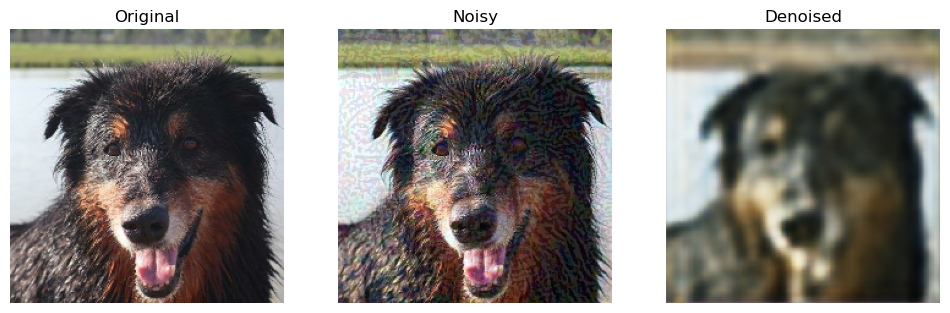

In [11]:
## 7. Example usage (simulating Android pipeline)
def process_image(image_path):
    # Load and preprocess
    img = load_image(image_path).numpy()
    
    # Model 1: Classify
    pred = model1.predict(np.expand_dims(img, 0))
    class_idx = np.argmax(pred)
    print(f"Original classification: {class_names[class_idx]} ({pred[0][class_idx]:.2f})")
    
    # Model 2: Add noise
    noisy_img = model2.add_noise(img)
    
    # Model 1: Classify noisy image
    noisy_pred = model1.predict(noisy_img)
    noisy_class = np.argmax(noisy_pred)
    print(f"Noisy classification: {class_names[noisy_class]} ({noisy_pred[0][noisy_class]:.2f})")
    
    # Model 3: Denoise
    denoised_img = model3.predict(noisy_img)
    
    # Model 1: Classify denoised image
    denoised_pred = model1.predict(denoised_img)
    denoised_class = np.argmax(denoised_pred)
    print(f"Denoised classification: {class_names[denoised_class]} ({denoised_pred[0][denoised_class]:.2f})")
    
    # Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_img[0])
    plt.title("Noisy")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_img[0])
    plt.title("Denoised")
    plt.axis('off')
    
    plt.show()

# Test with an example image
process_image(test_paths[1])